In [1]:
# Importing packages and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

ozone = pd.read_csv('Daily_Census_Tract-Level_Ozone_Concentrations__2011-2014_20241125.csv')
chronic_disease = pd.read_csv('U.S._Chronic_Disease_Indicators__CDI___2023_Release_20241125.csv')

## Preliminary data cleaning

In [2]:
codes = [30, 16, 45, 6, 36, 48]
state_codes = ['MT', 'ID', 'SC', 'CA', 'NY', 'TX']
questions = ['Current asthma prevalence among adults aged >= 18 years', 'Invasive cancer (all sites combined), incidence', 
             'Prevalence of chronic kidney disease among adults aged >= 18 years', 'Prevalence of chronic obstructive pulmonary disease among adults >= 18',
             'Prevalence of diagnosed diabetes among adults aged >= 18 years', 'Mortality from diseases of the heart']

# Chronic diseases
disease_q = chronic_disease[chronic_disease['Question'].isin(questions)] # Filtering to only include chosen questions
disease_q = disease_q[disease_q['YearStart'].isin([2011,2012,2013,2014])]
disease_q = disease_q[disease_q['LocationID'].isin(codes)]
disease_q = disease_q[['YearStart', 'LocationDesc', 'LocationID', 'Topic', 'Question', 'DataValueUnit', 'DataValue']]

filter = chronic_disease[chronic_disease['Question'].str.contains('mortality') | chronic_disease['Question'].str.contains('Mortality')] # Looking at mortality
diseases = filter[['YearStart', 'LocationDesc', 'LocationID', 'Topic', 'Question', 'DataValueUnit', 'DataValue']]
diseases = diseases[diseases['LocationID'].isin(codes)] # Filtering to chosen states
diseases

,YearStart,LocationDesc,LocationID,Topic,Question,DataValueUnit,DataValue
74,2010,California,6.0,Asthma,Asthma mortality rate,NaN,403.0
75,2017,California,6.0,Asthma,Asthma mortality rate,NaN,399.0
86,2020,Idaho,16.0,Asthma,Asthma mortality rate,Number,23.0
87,2010,Idaho,16.0,Asthma,Asthma mortality rate,NaN,21.0
106,2012,Montana,30.0,Asthma,Asthma mortality rate,NaN,NaN
...,...,...,...,...,...,...,...
617982,2015,South Carolina,45.0,Diabetes,Mortality with diabetic ketoacidosis reported ...,"cases per 100,000",NaN
617987,2015,Montana,30.0,Diabetes,Mortality with diabetic ketoacidosis reported ...,"cases per 100,000",NaN
618005,2013,Texas,48.0,Diabetes,Mortality with diabetic ketoacidosis reported ...,NaN,NaN
618014,2015,Texas,48.0,Diabetes,Mortality with diabetic ketoacidosis reported ...,"cases per 100,000",NaN


## EDA

Average ozone concentration by state

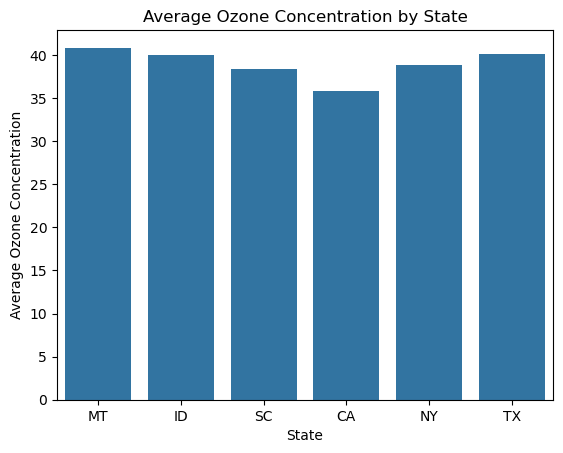

In [3]:
# Ozone
ozone_filter = ozone[ozone['statefips'].isin(codes)] # Filtering to only chosen states
ozone_total = ozone_filter.groupby('statefips')['ds_o3_pred'].mean().reset_index()
ozone_total['state'] = state_codes
sns.barplot(data=ozone_total, x='state', y='ds_o3_pred')
plt.title('Average Ozone Concentration by State')
plt.xlabel('State')
plt.ylabel('Average Ozone Concentration')
plt.show();

Mortality rates for selected states and diseases

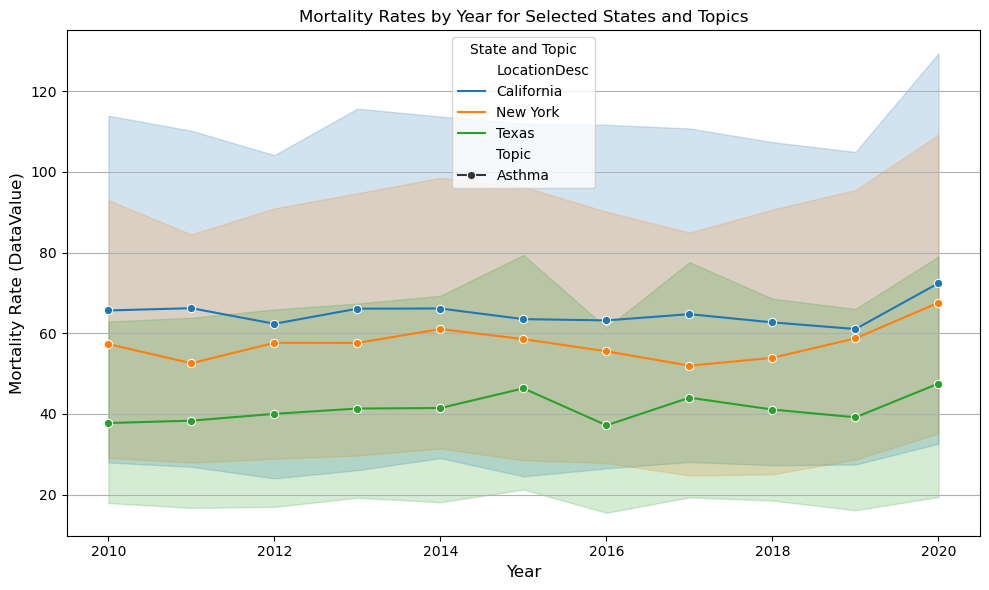

In [4]:
filtered_data = diseases[diseases['Topic'].isin(['Asthma'])]
filtered_data = filtered_data[filtered_data['LocationDesc'].isin(['California', 'New York', 'Texas'])]

# Plot a line plot with Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=filtered_data,
    x='YearStart',
    y='DataValue',
    hue='LocationDesc',
    style='Topic',
    markers=True
)

# Customize the plot
plt.title('Mortality Rates by Year for Selected States and Topics')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Mortality Rate (DataValue)', fontsize=12)
plt.legend(title='State and Topic', fontsize=10)
plt.grid(axis='y')
plt.tight_layout()

Comparing mortality rates in large and small states

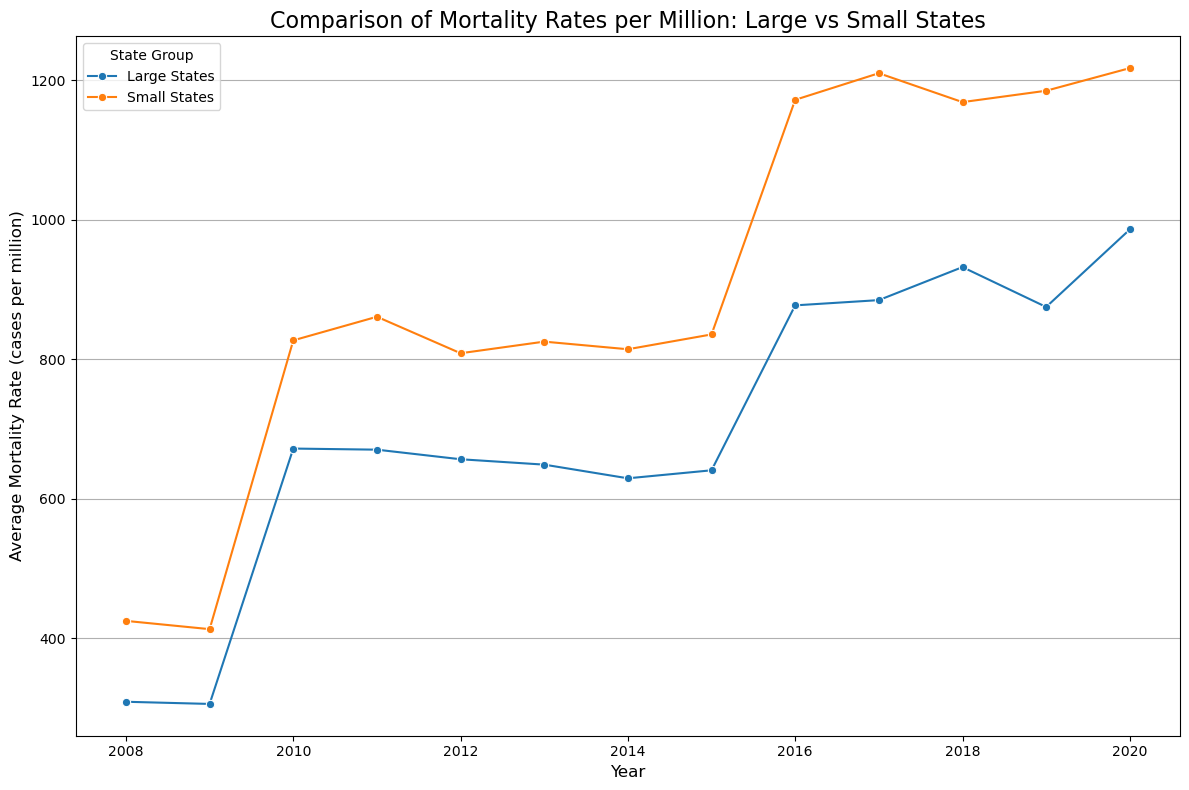

In [5]:
def normalize_datavalue(row):
    if row['DataValueUnit'] == 'cases per 1,000,000':
        return row['DataValue']  # Already normalized
    elif row['DataValueUnit'] in ['per 100,000', 'cases per 100,000']:
        return row['DataValue'] * 10  # Convert to per 1,000,000
    else:
        return np.nan  # Exclude 'Number' since it's not directly comparable

diseases['DataValueNormalized'] = diseases.apply(normalize_datavalue, axis=1)

diseases_normalized = diseases[~diseases['DataValueNormalized'].isna()]

large_states = ['California', 'New York', 'Texas']
small_states = ['Montana', 'Idaho', 'South Carolina']

large_data = diseases_normalized[diseases_normalized['LocationDesc'].isin(large_states)]
small_data = diseases_normalized[diseases_normalized['LocationDesc'].isin(small_states)]

large_avg = large_data.groupby('YearStart')['DataValueNormalized'].mean().reset_index()
large_avg['StateGroup'] = 'Large States'

small_avg = small_data.groupby('YearStart')['DataValueNormalized'].mean().reset_index()
small_avg['StateGroup'] = 'Small States'

combined_data = pd.concat([large_avg, small_avg])

plt.figure(figsize=(12, 8))
sns.lineplot(
    data=combined_data,
    x='YearStart',
    y='DataValueNormalized',
    hue='StateGroup',
    marker='o'
)

plt.title('Comparison of Mortality Rates per Million: Large vs Small States', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Mortality Rate (cases per million)', fontsize=12)
plt.legend(title='State Group', fontsize=10)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Mortality from heart disease

/tmp/ipykernel_59/127758070.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diseases_normalized['StateGroup'] = diseases_normalized['LocationDesc'].apply(
/tmp/ipykernel_59/127758070.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


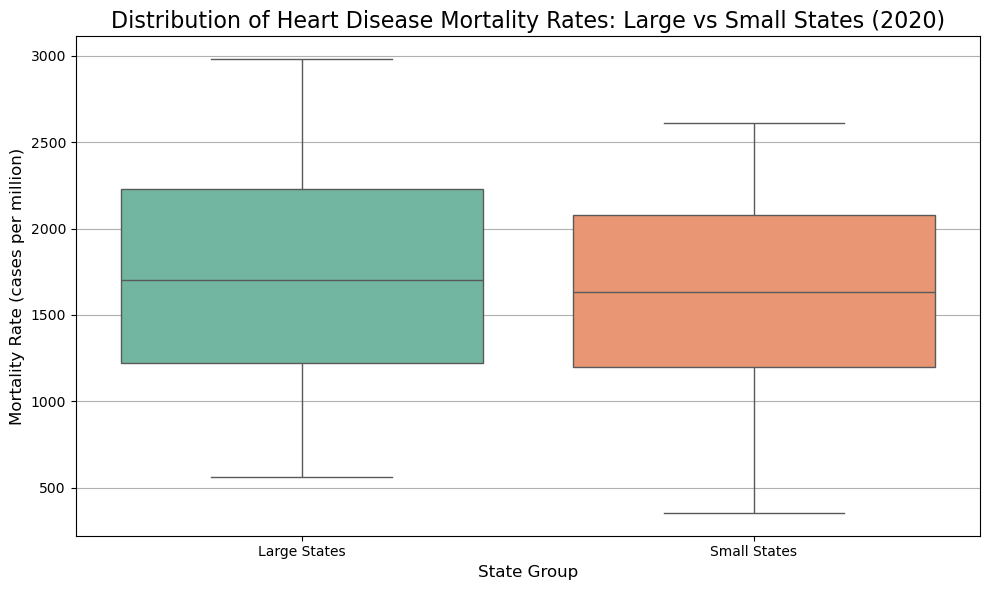

In [6]:
large_states = ['California', 'New York', 'Texas']
small_states = ['Montana', 'Idaho', 'South Carolina']

# Add a new column to classify states as "Large" or "Small"
diseases_normalized['StateGroup'] = diseases_normalized['LocationDesc'].apply(
    lambda x: 'Large States' if x in large_states else 'Small States' if x in small_states else None
)

# Filter data for only the six states and "Mortality from diseases of the heart"
filtered_data = diseases_normalized[
    (diseases_normalized['StateGroup'].notna()) &
    (diseases_normalized['Question'] == 'Mortality from diseases of the heart')
]

# Select a specific year (optional, e.g., 2020)
filtered_data = filtered_data[filtered_data['YearStart'] == 2020]  # Example: Focus on 2020

# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=filtered_data,
    x='StateGroup',
    y='DataValueNormalized',
    palette='Set2'
)

# Customize the plot
plt.title('Distribution of Heart Disease Mortality Rates: Large vs Small States (2020)', fontsize=16)
plt.xlabel('State Group', fontsize=12)
plt.ylabel('Mortality Rate (cases per million)', fontsize=12)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Comparing age distributions and COPD prevalence across states

In [7]:
# Looking at COPD specifically
copd = disease_q[disease_q['Topic']=='Chronic Obstructive Pulmonary Disease']
copd2011 = copd[copd.YearStart == 2011]
copd_grouped = copd2011.groupby('LocationDesc')[['DataValue']].mean()
copd_grouped = copd_grouped.reset_index()
copd_grouped = copd_grouped.rename(columns={'LocationDesc':'state', 'DataValue':'prevalence'})
copd_grouped

,state,prevalence
0,California,5.250000
1,Idaho,5.180000
2,Montana,7.033333
3,New York,5.758333
4,South Carolina,8.341667
5,Texas,6.442857


In [8]:
age2011 = pd.read_csv('age2011.csv')

# Cleaning age data
pattern = r'[a-zA-Z]([0-9]+)'
def column_clean(df):
    # Cleans column names and drops unnecessary columns
    df.columns = df.iloc[0].str.replace('!!', ' ')
    df = df.drop(df.columns[-1], axis=1)
    df = df.drop(columns=df.columns[df.columns.str.contains('Margin of Error')])
    df = df.drop(columns=df.columns[df.columns.str.contains('PERCENT IMPUTED')])
    df = df.drop(columns=df.columns[df.columns.str.contains('PERCENT ALLOCATED')])
    df = df.drop(columns=df.columns[df.columns.str.contains('Male')])
    df = df.drop(columns=df.columns[df.columns.str.contains('Female')])
    df = df.drop(columns=df.columns[df.columns.str.contains('dependency')])
    df = df.drop(columns=df.columns[df.columns.str.contains('SUMMARY INDICATORS')])
    df = df.drop(columns=df.columns[df.columns.str.contains('SELECTED AGE CATEGORIES')])
    df['Geography'] = df['Geography'].str.extract(pattern) # Extracting correct GEOID
    df = df.iloc[1:]
    return df

age_clean = column_clean(age2011)
age_cols = age_clean.columns[3:]
age = age_clean.melt(id_vars=['Geography', 'Geographic Area Name'], 
                  value_vars=age_cols, 
                  var_name='age_group', 
                  value_name='percent_pop')

age['age_group'] = age['age_group'].str.extract(r'^Total Estimate AGE (.*)$')
age['percent_pop'] = age['percent_pop'].astype('float')

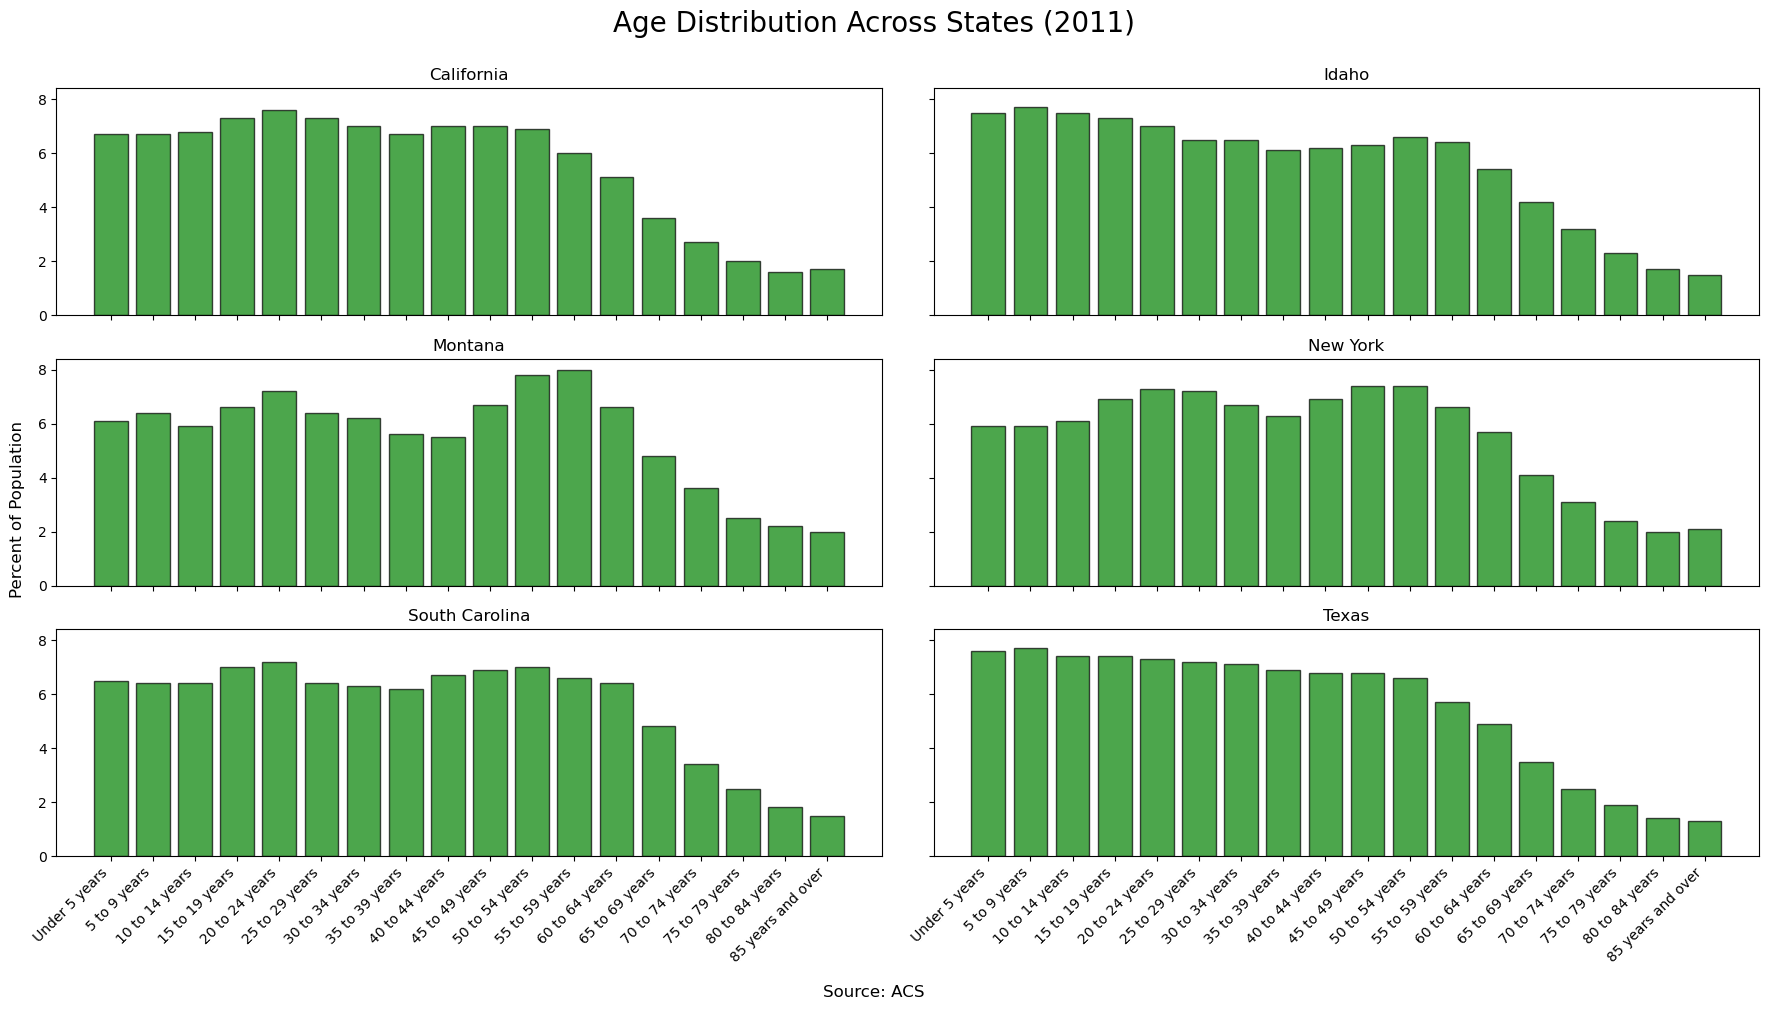

In [9]:
# Plotting age distributions
states = ['California', 'Idaho', 'Montana', 'New York', 'South Carolina', 'Texas']
plot, axes = plt.subplots(3, 2, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each state separately
for ax, state in zip(axes, states):
    age_state = age[age['Geographic Area Name'] == state]
    ax.bar(age_state['age_group'], age_state['percent_pop'], color='green', edgecolor='black', alpha=0.7)
    ax.set_title(f'{state}')
    ax.set_xticks(range(len(age_state['age_group'])))
    ax.set_xticklabels(age_state['age_group'], rotation=45, ha='right')

plot.supylabel('Percent of Population')
plot.supxlabel('Source: ACS')

plot.suptitle('Age Distribution Across States (2011)', y=1, size=20)

plt.tight_layout()
plt.show()

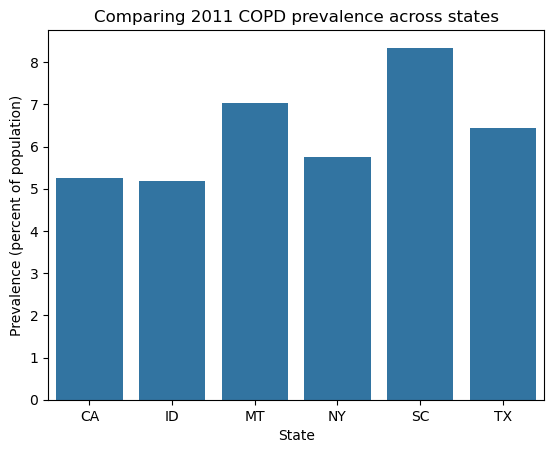

In [10]:
# Plotting COPD prevalence across all states
state_codes = ['CA', 'ID', 'MT', 'NY', 'SC', 'TX']
copd_grouped['st_code'] = state_codes
sns.barplot(data=copd_grouped, x='st_code', y='prevalence')
plt.xlabel('State')
plt.ylabel('Prevalence (percent of population)')
plt.title('Comparing 2011 COPD prevalence across states');

## Research questions

QUESTIONS/TOPICS:
- Current asthma prevalence among adults aged >= 18 years
- Invasive cancer (all sites combined), incidence
- Prevalence of chronic kidney disease among adults aged >= 18 years
- Prevalence of chronic obstructive pulmonary disease among adults >= 18
- Prevalence of diagnosed diabetes among adults aged >= 18 years
- Mortality from diseases of the heart

## Multiple Hypothesis Testing
Research question: Is there an association between ground-level ozone concentration and the prevalence of different chronic diseases?

In [11]:
questions = ['Current asthma prevalence among adults aged >= 18 years', 'Invasive cancer (all sites combined), incidence', 
             'Prevalence of chronic kidney disease among adults aged >= 18 years', 'Prevalence of chronic obstructive pulmonary disease among adults >= 18',
             'Prevalence of diagnosed diabetes among adults aged >= 18 years', 'Mortality from diseases of the heart']

filtered = chronic_disease[chronic_disease['Question'].isin(questions)]
filtered = filtered[filtered['LocationID'].isin(codes)]
filtered = filtered[['YearStart', 'YearEnd', 'LocationDesc', 'LocationID', 'Topic', 'Question', 'DataValueUnit', 'DataValue', 'DataSource',
                     'StratificationCategoryID1', 'Stratification1']]
filtered = filtered[filtered['YearStart'].isin([2011, 2012, 2013, 2014])]

# Separating each disease
asthma = filtered[filtered.Topic == 'Asthma']
cancer = filtered[filtered['Topic'].str.contains('Cancer')]
kidney = filtered[filtered['Topic'].str.contains('Kidney')]
copd = filtered[filtered['Topic'].str.contains('Pulmonary')]
diabetes = filtered[filtered['Topic'].str.contains('Diabetes')]
heart = filtered[filtered['Topic'].str.contains('Cardiovascular')]

# Filtering ozone data to only include states we aren't interested in
ozone = ozone[ozone['statefips'].isin(codes)]
median_ozone = ozone['ds_o3_pred'].median()
ozone['high'] = ozone['ds_o3_pred'] > median_ozone # Classifying ozone as "high" if it is above the median

In [12]:
# Merging chronic disease and ozone data, cleaning column names
def clean_and_merge(df):
    merge = pd.merge(df, ozone, left_on=['YearStart', 'LocationID'], right_on=['year', 'statefips'])
    merge = merge[['year', 'statefips', 'LocationDesc', 'Topic', 'Question', 'DataValueUnit', 'DataValue', 'ds_o3_pred', 'high', 'DataSource',
                   'StratificationCategoryID1', 'Stratification1']]
    merge = merge.rename(columns={'LocationDesc':'location', 'Topic':'topic', 'Question':'question', 'DataValueUnit':'unit', 'DataValue':'value'})
    merge = merge[merge['StratificationCategoryID1'] == 'OVERALL']
    merge = merge[['year', 'statefips', 'location', 'topic', 'question', 'unit', 'value', 'ds_o3_pred', 'high']]
    df = merge
    return df

kidney = clean_and_merge(kidney)
kidney = kidney[kidney.unit == '%']
asthma = clean_and_merge(asthma)
asthma = asthma[asthma.unit == '%']
cancer = clean_and_merge(cancer)
cancer = cancer[cancer.unit == 'per 100,000']
copd = clean_and_merge(copd)
copd = copd[copd.unit == '%']
diabetes = clean_and_merge(diabetes)
diabetes = diabetes[diabetes.unit == '%']
heart = clean_and_merge(heart)
heart = heart[heart.unit == 'cases per 100,000']

Hypotheses:

Null: There is no difference in the number of cases of [CHRONIC DISEASE] between areas with high ozone concentration and low ozone concentration.

Alternative: There is a difference in the number of cases  of [CHRONIC DISEASE] between areas with high ozone concentration and low ozone concentration.

In [13]:
def ab_test(df, reps):
    differences = []
    # Find observed difference in means
    grouped = df.groupby('high')[['value']].mean()
    means = grouped['value'].values
    observed_diff = abs(means[1] - means[0]) # Subtracting mean of high ozone locations from mean of low ozone locations
    print(means[1]-means[0])

    for i in np.arange(reps):
        # Shuffle labels
        shuffled = np.random.permutation(df['high'])
        df['shuffled'] = shuffled
    
        # Take new difference in means from shuffled labels
        shuffle_group = df.groupby('shuffled')[['value']].mean()
        new_means = shuffle_group['value'].values
        diff = abs(new_means[1] - new_means[0])
        differences.append(diff) # these should be 0

    p_val = np.count_nonzero(differences >= observed_diff) / reps # this should be close to 0 in order to reject null 
    return p_val

In [14]:
repetitions = 5000

np.random.seed(10)
cancer_p = ab_test(cancer, repetitions)
print('cancer: ' + str(cancer_p))
copd_p = ab_test(copd, repetitions)
print('copd: ' + str(copd_p))
heart_p = ab_test(heart, repetitions)
print('cardiovascular disease: ' + str(heart_p))
diabetes_p = ab_test(diabetes, repetitions)
print('diabetes: ' + str(diabetes_p))
asthma_p = ab_test(asthma, repetitions)
print('asthma: ' + str(asthma_p))
kidney_p = ab_test(kidney, repetitions)
print('kidney disease: ' + str(kidney_p))

p_vals = [cancer_p, copd_p, heart_p, diabetes_p, asthma_p, kidney_p]
p_vals.sort() # Sorting p-values
p_vals

-61.712500000000034
cancer: 0.0006
-0.4583333333333339
copd: 0.1068
-18.82916666666665
cardiovascular disease: 0.0056
1.548571428571428
diabetes: 0.001
-0.7333333333333325
asthma: 0.009
0.1958333333333333
kidney disease: 0.035


[0.0006, 0.001, 0.0056, 0.009, 0.035, 0.1068]

In [15]:
tests = ['cancer', 'diabetes', 'heart', 'asthma', 'kidney', 'copd'] # Sorted labels

In [16]:
# Bonferroni correction (controlling FWER)
fpr = 0.01
num_tests = 6
new_threshold = fpr / num_tests

rejected = []
for i in range(num_tests):
    p_val = p_vals[i]
    test = tests[i]
    if p_val <= new_threshold:
        rejected.append(test)

print('rejected nulls: ' + str(rejected))

rejected nulls: ['cancer', 'diabetes']


In [17]:
# Benjamini Yekutieli (controlling FDR)
c_m = 1/1 + 1/2 + 1/3 + 1/4 + 1/5 + 1/6

thresholds = (np.arange(1, num_tests+1) / (num_tests + c_m)) * fpr

rejections = [] 

for i in range(num_tests):
    p = p_vals[i]
    thresh = thresholds[i]
    print(i)
    print(p <= thresh)

new_thresh = p_vals[1]

for i in range(num_tests):
    p_val = p_vals[i]
    test = tests[i]
    if p_val <= new_thresh:
        rejections.append(test)

print('rejected nulls: ' + str(rejections))

0
True
1
True
2
False
3
False
4
False
5
False
rejected nulls: ['cancer', 'diabetes']


## Causal Inference
Research Question: Do different ozone concentration levels have a causal relationship with the prevalence of cancer?

In [31]:
# Looking at cancer only, redefining cancer dataframe
filtered = chronic_disease[chronic_disease['Question'].isin(questions)]
filtered = filtered[filtered['LocationID'].isin(codes)]
filtered = filtered[['YearStart', 'YearEnd', 'LocationDesc', 'LocationID', 'Topic', 'Question', 'DataValueUnit', 'DataValue', 'DataSource',
                     'StratificationCategoryID1', 'Stratification1']]
filtered = filtered[filtered['YearStart'].isin([2011, 2012, 2013, 2014])]
cancer = filtered[filtered['Topic'].str.contains('Cancer')]

ozone = ozone[ozone['statefips'].isin(codes)]
median_ozone = ozone['ds_o3_pred'].median()
ozone['high'] = ozone['ds_o3_pred'] > median_ozone # Classifying ozone as "high" if it is above the median

def clean_and_merge_causal(df):
    merge = pd.merge(df, ozone, left_on=['YearStart', 'LocationID'], right_on=['year', 'statefips'])
    merge = merge[['year', 'statefips', 'LocationDesc', 'Topic', 'Question', 'DataValueUnit', 'DataValue', 'ds_o3_pred', 'high', 'DataSource',
                   'StratificationCategoryID1', 'Stratification1']]
    merge = merge.rename(columns={'LocationDesc':'location', 'Topic':'topic', 'Question':'question', 'DataValueUnit':'unit', 'DataValue':'value'})
    merge = merge[['year', 'statefips', 'location', 'topic', 'question', 'unit', 'value', 'ds_o3_pred', 'high', 'StratificationCategoryID1', 'Stratification1']]
    df = merge
    return df

cancer = clean_and_merge_causal(cancer)
cancer = cancer[cancer.unit == 'per 100,000']
cancer = cancer[cancer['StratificationCategoryID1'] != 'OVERALL']
cancer = cancer.dropna(subset=['value'])
cancer['high'] = cancer['high'].astype(int)
cancer

,year,statefips,location,topic,question,unit,value,ds_o3_pred,high,StratificationCategoryID1,Stratification1
3,2011,6,California,Cancer,"Invasive cancer (all sites combined), incidence","per 100,000",445.3,39.968547,1,GENDER,Male
4,2013,45,South Carolina,Cancer,"Invasive cancer (all sites combined), incidence","per 100,000",604.0,36.254950,0,GENDER,Male
13,2011,48,Texas,Cancer,"Invasive cancer (all sites combined), incidence","per 100,000",1.4,42.251668,1,RACE,American Indian or Alaska Native
17,2013,30,Montana,Cancer,"Invasive cancer (all sites combined), incidence","per 100,000",1.2,37.704105,0,RACE,"Black, non-Hispanic"
19,2011,48,Texas,Cancer,"Invasive cancer (all sites combined), incidence","per 100,000",225.8,42.251668,1,RACE,Hispanic
...,...,...,...,...,...,...,...,...,...,...,...
567,2012,30,Montana,Cancer,"Invasive cancer (all sites combined), incidence","per 100,000",237.5,38.278931,0,RACE,Hispanic
568,2012,6,California,Cancer,"Invasive cancer (all sites combined), incidence","per 100,000",657.9,41.231641,1,RACE,"White, non-Hispanic"
569,2014,45,South Carolina,Cancer,"Invasive cancer (all sites combined), incidence","per 100,000",288.9,37.427165,0,RACE,Hispanic
571,2013,36,New York,Cancer,"Invasive cancer (all sites combined), incidence","per 100,000",31.2,36.113804,0,RACE,Asian or Pacific Islander


In [32]:
# One Hot Encoding for Categorical Variables
cancer = pd.get_dummies(cancer, dtype=float)
cancer

,year,statefips,value,ds_o3_pred,high,location_California,location_Idaho,location_Montana,location_New York,location_South Carolina,...,"unit_per 100,000",StratificationCategoryID1_GENDER,StratificationCategoryID1_RACE,Stratification1_American Indian or Alaska Native,Stratification1_Asian or Pacific Islander,"Stratification1_Black, non-Hispanic",Stratification1_Female,Stratification1_Hispanic,Stratification1_Male,"Stratification1_White, non-Hispanic"
3,2011,6,445.3,39.968547,1,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2013,45,604.0,36.254950,0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13,2011,48,1.4,42.251668,1,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
17,2013,30,1.2,37.704105,0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
19,2011,48,225.8,42.251668,1,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,2012,30,237.5,38.278931,0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
568,2012,6,657.9,41.231641,1,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
569,2014,45,288.9,37.427165,0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
571,2013,36,31.2,36.113804,0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [33]:
def fit_OLS_model(df, target_variable, explanatory_variables, intercept = False):

    target = df[target_variable]
    inputs = df[explanatory_variables]
    if intercept:
        inputs = sm.add_constant(inputs)
    
    fitted_model = sm.OLS(target, inputs).fit()
    return(fitted_model)

def mean_squared_error(true_vals, predicted_vals):
    return np.mean((true_vals - predicted_vals) ** 2)

In [34]:
import statsmodels.api as sm
linear_model = fit_OLS_model(cancer, 'value', ['high', 'location_California', 'location_Idaho', 'location_Montana', 
                                            'location_New York', 'location_South Carolina', 'location_Texas', 
                                             'Stratification1_American Indian or Alaska Native', 'Stratification1_Asian or Pacific Islander',
                                            'Stratification1_Black, non-Hispanic', 'Stratification1_Female',
                                           'Stratification1_Hispanic', 'Stratification1_Male', 
                                             'Stratification1_White, non-Hispanic'], intercept = False)
print(linear_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  value   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     145.6
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.20e-120
Time:                        17:25:41   Log-Likelihood:                -1910.5
No. Observations:                 328   AIC:                             3847.
Df Residuals:                     315   BIC:                             3896.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [35]:
mean_treatment = cancer[cancer['high'] == 1]['value'].mean()

causal_effect = cancer[cancer['high'] == 1]['value'].mean() - cancer[cancer['high'] == 0]['value'].mean()
causal_effect

5.3866071428571445

In [36]:
def draw_tau_hat(data = cancer, random_state=None):
    sample = data.sample(frac = 1, random_state = random_state, replace = True)
    fit_model = sm.OLS(sample['value'], sample[['high', 'location_California', 'location_Idaho', 'location_Montana', 
                                            'location_New York', 'location_South Carolina', 'location_Texas', 
                                             'Stratification1_American Indian or Alaska Native', 'Stratification1_Asian or Pacific Islander',
                                            'Stratification1_Black, non-Hispanic', 'Stratification1_Female',
                                           'Stratification1_Hispanic', 'Stratification1_Male', 
                                             'Stratification1_White, non-Hispanic']]).fit()
    estimated_ate = fit_model.params['high']
    return estimated_ate

def get_bootstrapped_ate(data = cancer, n=1000):
    estimates = []
    for i in np.arange(n):
        estimate = draw_tau_hat(data, random_state = i)
        estimates.append(estimate)
    return estimates

In [37]:
ates = get_bootstrapped_ate(cancer, 1000)
confidence_interval = [np.percentile(ates, 2.5), 
                       np.percentile(ates, 97.5)]
print(f"95% confidence interval range: {confidence_interval}")

95% confidence interval range: [-18.031180341589664, 16.239194718724256]


Text(0.5, 1.0, 'Bootstrapped Estimates of the ATE')

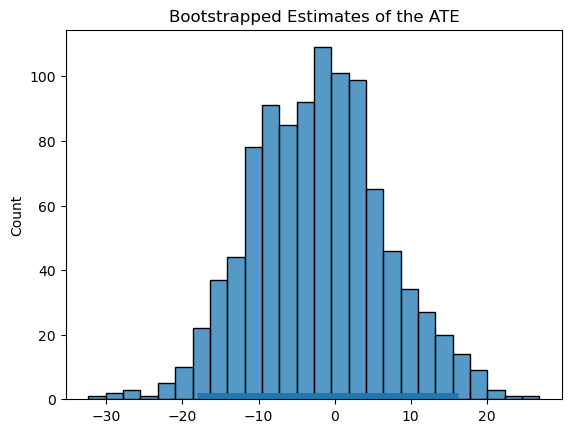

In [38]:
sns.histplot(ates)
plt.hlines(1, confidence_interval[0], confidence_interval[1], linewidth=5)
plt.title("Bootstrapped Estimates of the ATE");